In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('C:/Users/ABHISHJA/Downloads/train_qWM28Yl.csv')
data

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,ID58588,0.355089,0.13,0.644231,C8,8794,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
58588,ID58589,1.199642,0.02,0.519231,C14,7788,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
58589,ID58590,1.162273,0.05,0.451923,C5,34738,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
58590,ID58591,1.236307,0.14,0.557692,C8,8794,1,B2,M6,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,K Series Dual jet,2,No,Yes,No,Yes,No,Drum,1197,4,Manual,5,Electric,4.8,3845,1735,1530,1335,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0


In [3]:
df = data.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

### Feature Engineering

In [5]:
df['Max_Torque'] = df['max_torque'].apply(lambda x: float(x.split('N')[0]))
df['rpm_at_max_torque'] = df['max_torque'].apply(lambda x: int(x.split('@')[1].split('r')[0]))
df['Max_Power'] = df['max_power'].apply(lambda x: float(x.split('b')[0]))
df['rpm_at_max_power'] = df['max_power'].apply(lambda x: int(x.split('@')[1].split('r')[0]))

In [6]:
df = df.drop(['max_torque','max_power', 'policy_id'], axis=1)

In [7]:
X = df.drop(['is_claim'], axis=1)
y = df['is_claim']

In [55]:
numerical_features = X.select_dtypes(exclude='O').columns
continuous_features = [feature for feature in numerical_features if len(df[feature].unique())>20]

In [56]:
print(len(numerical_features), len(continuous_features))

19 4


### Outlier Detections

By Z-score Method

In [57]:
for feature in continuous_features:
    mean = df[feature].mean()
    std = df[feature].std()
    
    lower_bound = mean - 3*std
    upper_bound = mean + 3*std
    
    percentage = (len(df[(df[feature]<lower_bound) | (df[feature]>upper_bound)])/len(df))*100
    print(f"{feature} has {percentage:.5f}% Outliers")

policy_tenure has 0.00000% Outliers
age_of_car has 0.57004% Outliers
age_of_policyholder has 0.21163% Outliers
population_density has 5.38469% Outliers


By Inter-Quantile Range Method

In [58]:
for feature in continuous_features:
    q1, q3 = np.percentile(df[feature], [25, 75])
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    
    percentage = (len(df[(df[feature]<lower_bound) | (df[feature]>upper_bound)])/len(df)) * 100
    
    print(f"{feature} has {percentage:.5f}% Outliers")

policy_tenure has 0.00000% Outliers
age_of_car has 0.45911% Outliers
age_of_policyholder has 0.37718% Outliers
population_density has 6.22440% Outliers


In [59]:
discrete_features = [feature for feature in numerical_features if feature not in continuous_features]

In [70]:
len(discrete_features)

15

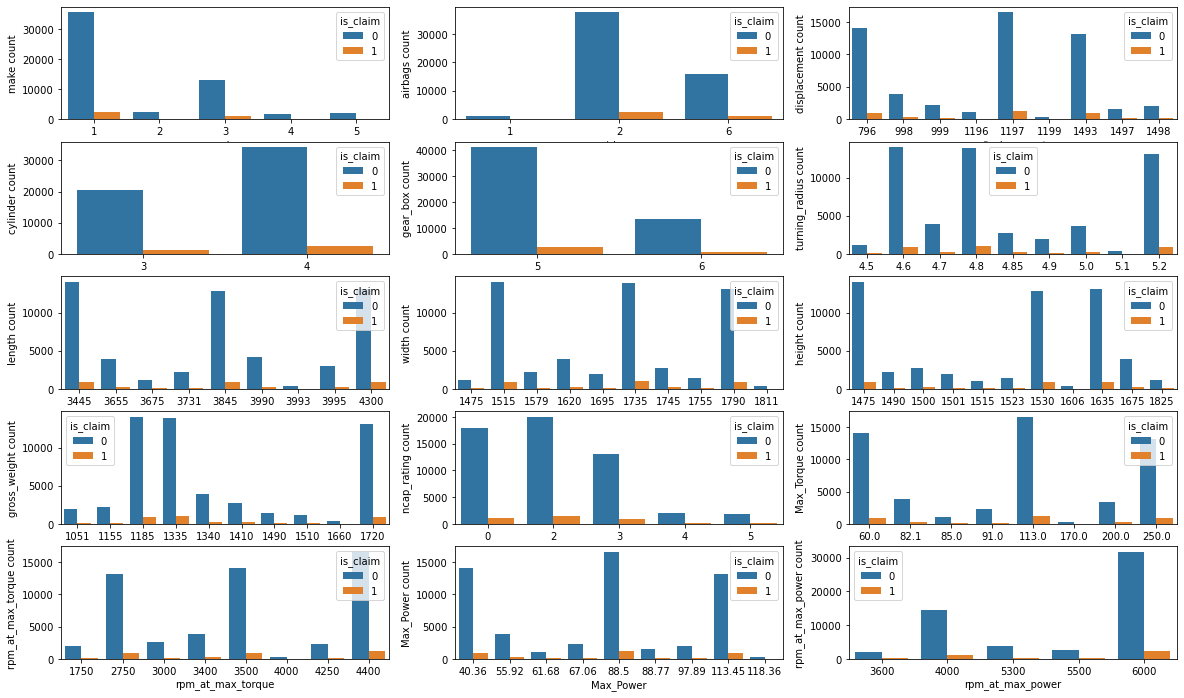

In [85]:
n_rows = 5
n_cols = 3
n_features = 0
p = 1

plt.figure(figsize=(20,12))
for i in range(1, n_rows+1):
    plt.subplot(n_rows, n_cols, p)
    sns.countplot(x=discrete_features[n_features], data=df , hue='is_claim')
    plt.ylabel(discrete_features[n_features]+' count')
    n_features += 1
    p += 1
    
    plt.subplot(n_rows, n_cols, p)
    sns.countplot(x=discrete_features[n_features], data=df , hue='is_claim')
    plt.ylabel(discrete_features[n_features]+' count')
    n_features += 1
    p += 1
    
    plt.subplot(n_rows, n_cols, p)
    sns.countplot(x=discrete_features[n_features], data=df , hue='is_claim')
    plt.ylabel(discrete_features[n_features]+' count')
    n_features += 1
    p += 1

## Feature Selection

feature selection by Information Gain 

In [400]:
# Extracting Numerical Features

numerical_features = X.select_dtypes(exclude='O').columns

In [401]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X[numerical_features], y)

In [402]:
mutual_info

array([3.07747598e-03, 2.48516413e-03, 1.88455401e-05, 2.29472826e-03,
       3.73050221e-03, 5.96320247e-03, 2.17747966e-03, 5.67420107e-03,
       7.90620823e-03, 1.15013796e-03, 7.55088561e-04, 1.09711178e-03,
       1.38443561e-03, 2.04073320e-03, 1.56059727e-03, 2.12673108e-03,
       3.26184106e-03, 9.60044256e-04, 4.52198114e-03])

In [403]:
numeric_info = pd.DataFrame(mutual_info, index=X[numerical_features].columns, columns=['Dependencies'])

Higher the value, more important the feature is

In [404]:
numeric_info = numeric_info.sort_values(by='Dependencies', ascending=False)
numeric_info

,Dependencies
gear_box,0.007906
airbags,0.005963
cylinder,0.005674
rpm_at_max_power,0.004522
make,0.003731
rpm_at_max_torque,0.003262
policy_tenure,0.003077
age_of_car,0.002485
population_density,0.002295
displacement,0.002177


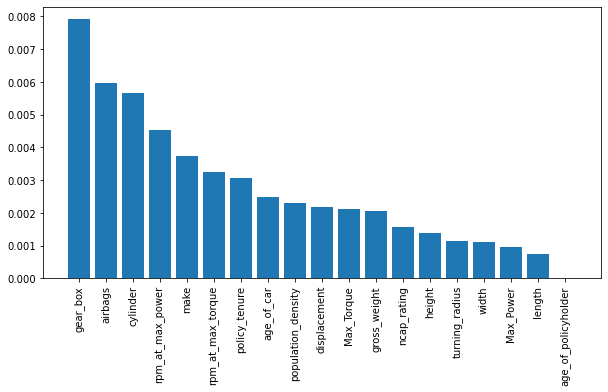

In [405]:
plt.figure(figsize=(10,5))
plt.bar(numeric_info.index, numeric_info['Dependencies'])
plt.xticks(rotation='vertical')
plt.show()

In [406]:
# selecting top 5 features

numeric_features = numeric_info.index[:5]

In [407]:
numeric_features

Index(['gear_box', 'airbags', 'cylinder', 'rpm_at_max_power', 'make'], dtype='object')

Feature selection by Chi-Square Test <br>
we also need to convert the categorical features with the help of Label Encoder <br>
we get f-score and p-value from this test. Higher the f-score, more important the feature is. <br>
if p-value is less than 0.05, feature is significant

In [408]:
# Extracting Categorical Features

categorical_features = X.select_dtypes(include='O').columns

In [409]:
from sklearn.preprocessing import LabelEncoder

categorical_data = pd.DataFrame()


for feature in categorical_features:
    encoder = LabelEncoder()
    categorical_data[feature]= encoder.fit_transform(X[feature])

In [410]:
categorical_data

,area_cluster,segment,model,fuel_type,engine_type,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,transmission_type,steering_type,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert
0,0,0,0,0,6,0,0,0,1,0,1,1,2,0,0,0,0,0,0,0,1,0,0,0,1
1,11,0,0,0,6,0,0,0,1,0,1,1,2,0,0,0,0,0,0,0,1,0,0,0,1
2,15,0,0,0,6,0,0,0,1,0,1,1,2,0,0,0,0,0,0,0,1,0,0,0,1
3,16,3,3,2,2,1,1,0,1,1,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1
4,17,0,4,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,20,0,4,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,1,1,1
58588,5,0,0,0,6,0,0,0,1,0,1,1,2,0,0,0,0,0,0,0,1,0,0,0,1
58589,17,0,0,0,6,0,0,0,1,0,1,1,2,0,0,0,0,0,0,0,1,0,0,0,1
58590,20,2,7,2,8,0,1,0,1,0,1,1,0,1,0,0,0,1,1,1,1,1,1,1,1


In [411]:
from sklearn.feature_selection import chi2

f_p_values = chi2(categorical_data, y)

In [412]:
p_values = f_p_values[1]

In [413]:
p_values < 0.05

array([ True, False,  True, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [414]:
cat_info = pd.Series(f_p_values[1], index=categorical_data.columns).sort_values(ascending=True)
cat_info

area_cluster                        0.000017
model                               0.018879
is_adjustable_steering              0.034551
steering_type                       0.035419
fuel_type                           0.052434
is_front_fog_lights                 0.063302
is_brake_assist                     0.076660
segment                             0.083000
is_driver_seat_height_adjustable    0.095754
is_day_night_rear_view_mirror       0.127926
is_central_locking                  0.398845
is_power_door_locks                 0.398845
is_ecw                              0.398845
is_esc                              0.548243
is_rear_window_wiper                0.588605
is_rear_window_washer               0.588605
is_rear_window_defogger             0.613521
is_parking_sensors                  0.681706
engine_type                         0.797218
is_parking_camera                   0.869236
is_tpms                             0.882018
is_speed_alert                      0.889279
transmissi

Taking out the significant features

In [415]:
categorical_features = cat_info.index[:4]

In [416]:
categorical_features

Index(['area_cluster', 'model', 'is_adjustable_steering', 'steering_type'], dtype='object')

In [417]:
df['is_claim'].value_counts()

0    54844
1     3748
Name: is_claim, dtype: int64

As we can see we have lots of for people who are not going to claim the insurance,  <br>
but we have small data for people who are going to claim the information. This is clearly an Imbalanced Dataset. <br>
we need to take care of this imbalance.
### Types of Methods to tackle the Imbalance.
- 1. Under Sampling
        Here we count the minority class and take the same no of samples from majority class.
        But we are loosing the data here.
- 2. Over Sampling
        Here we count the majority class and duplicate the minority class such that no of records for both minority and majority class is same

#### Under Sampling

In [418]:
minority = df[df['is_claim']==1]
majority = df[df['is_claim']==0].sample(len(minority))

In [419]:
resampled = pd.concat([minority, majority])

In [420]:
resampled = resampled.sample(frac=1)

In [421]:
resampled.index = range(len(resampled))

In [422]:
X = resampled.drop('is_claim', axis=1)
y = resampled['is_claim']

In [423]:
X = X[list(numeric_features) + list(categorical_features)]

In [424]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [425]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

### Building a Pipeline

In [426]:
categorical_pipeline = Pipeline([('label_encoder', OneHotEncoder(handle_unknown='ignore'))])
numerical_pipeline = Pipeline([('scaler', StandardScaler())])

X_train[numeric_features].columns

transforming_features = ['cylinder','gear_box','airbags','make','rpm_at_max_torque']

In [429]:
preprocessor = ColumnTransformer([('categorical', categorical_pipeline, categorical_features)
                                 ,('numerical', numerical_pipeline, numeric_features)])

In [430]:
final_pipeline = Pipeline([('preprocessing', preprocessor),
                           ('xgboost', XGBClassifier())])

In [431]:
final_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('label_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['area_cluster', 'model', 'is_adjustable_steering', 'steering_type'], dtype='object')),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['gear_box', 'airbags', 'cylinder', 'rpm_at_...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                       

param = {'xgboost__max_depth': [5,10,20,30,50,70,100],
         'xgboost__n_estimators': [100,150,200,300],
                 }

grid = GridSearchCV(estimator=final_pipeline, scoring='f1', param_grid=param, cv=5).fit(X_train, y_train)

y_pred = grid.best_estimator_.predict(X_test)
f1_score(y_test, y_pred)

In [432]:
param2 = {'xgboost__max_depth': [5,10,20,30],
         'xgboost__n_estimators': [200, 250,300,350],
          'xgboost__learning_rate': [0.01, 0.05, 0.1, 0.5, 1]
        }

In [433]:
grid2 = GridSearchCV(estimator=final_pipeline, scoring='f1', param_grid=param2, cv=5).fit(X_train, y_train)

In [434]:
y_pred2 = grid2.best_estimator_.predict(X_test)
f1_score(y_test, y_pred2)

0.5719424460431655

### Predicting for test data

In [370]:
test_data = pd.read_csv('C:/Users/ABHISHJA/Downloads/test_zo1G9sv.csv')

In [371]:
test_data['rpm_at_max_torque'] = test_data['max_torque'].apply(lambda x: int(x.split('@')[1].split('r')[0]))
test_data['rpm_at_max_power'] = test_data['max_power'].apply(lambda x: int(x.split('@')[1].split('r')[0]))

In [372]:
policy_id = test_data['policy_id']

test_data = test_data[list(numeric_features) + list(categorical_features)]

In [373]:
y_pred_test_data = grid2.best_estimator_.predict(test_data)

In [374]:
sub = pd.concat([policy_id, pd.DataFrame(y_pred_test_data, columns=['is_claim'])], axis=1)
sub.to_csv('submission(abhishek)2.csv', index=False)